In [27]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns; sns.set(color_codes=True)
from tqdm import tqdm
import pandas as pd


In [28]:
# settings

n_input = 13
n_output = 1
n_hidden = 20
n_layers = 1000

ini_mean = 0 
ini_stddev = 1/(2*n_hidden)

grad_drop = 0.5
alpha = 0.9
beta = 1.0

batch_size = 64

In [29]:
# the optimizer


class GradientProcessor(object):
    """
    grad_shape: shape of gradient; equivalently, shape of parameter matrix
    dropout: average percentage of partial derivatives masked from gradient update
    alpha: decay for exponential moving average of deltabar
    beta: weight of deltabar on gradient update
    scale: if False, use absolute value of gradient differences; if True, use proportion of current parameters
    """
    
    def __init__(self, grad_shape, dropout, alpha, beta, scale=False):
        self.deltabar = tf.zeros(shape=grad_shape,dtype=tf.float32)
        self.initial_update = True
        self.regular_update = False
        self.dropout = dropout
        self.alpha = alpha
        self.beta = beta
        self.scale = scale
        self.last_gradient = None
        self.last_mask = tf.ones(shape=grad_shape, dtype=tf.float32)
        
        self.debug = True

    def mask(self, gradient):
        self.last_mask = tf.floor(tf.random_uniform(shape=gradient.shape,dtype=tf.float32) + 1 - self.dropout)
        return tf.multiply(gradient,self.last_mask)
        
    def _maskinv(self, mask):
        return mask * -1 + 1
        
    def _calc_delta_t(self, gradient, parameters=None):
        maskinv = self._maskinv(self.last_mask)
        if self.last_gradient is None:
            self.last_gradient = gradient
        else:
            self.regular_update = True
            
        if self.scale is True:
            delta_t = tf.multiply(tf.divide((gradient-self.last_gradient), parameters) ,maskinv) + tf.multiply(self.deltabar, self.last_mask)
        else:
            delta_t = tf.multiply((gradient-self.last_gradient), maskinv) + tf.multiply(self.deltabar, self.last_mask)
        
        return delta_t
    
    def _update_deltabar(self, gradient, parameters=None):
        delta_t = self._calc_delta_t(gradient, parameters)
        if self.initial_update is True:
            self.deltabar = delta_t
            if self.regular_update is True:
                self.initial_update = False
        else:
            self.deltabar = (self.alpha)*self.deltabar + (1-self.alpha)*delta_t
        #update last gradient for next time
        self.last_gradient = gradient   
    
    def process(self, gradient, parameters=None):
        self._update_deltabar(gradient,parameters)
        if self.scale is True:
            update = gradient + self.beta*tf.multiply(self.deltabar,parameters)
        else:
            update = gradient + self.beta*self.deltabar
        
        return self.mask(update)
        
        
def process_gradients(processors, grads_and_vars):
    return[(processor.process(gv[0],gv[1]),gv[1]) for processor, gv in zip(processors,grads_and_vars)]  

In [30]:
# the network


hidden_dict = {}

num_params = (n_input*n_hidden) + n_hidden + (n_hidden*n_hidden*(n_layers)) + (n_output*n_hidden) + n_output


activation = tf.nn.relu

def weight_matrix(n_in,n_out):
    return tf.Variable(
        tf.truncated_normal(shape=(n_in,n_out), mean=ini_mean, stddev=ini_stddev)
        ,dtype=tf.float32)

def bias_matrix(n_to):
    return tf.Variable(tf.zeros(shape=(1,n_to),dtype=tf.float32))
           
    

input_layer = tf.placeholder(shape=(None,n_input),dtype=tf.float32)
output_truth = tf.placeholder(shape=(None,n_output),dtype=tf.float32)


for n in range(1,n_layers+1):
    hidden_dict[n] = {}
    if n == 1:
        hidden_dict[n]['weights'] = weight_matrix(n_input,n_hidden)
        hidden_dict[n]['bias'] = bias_matrix(n_hidden)
        hidden_dict[n]['layer'] = activation(tf.matmul(input_layer,hidden_dict[n]['weights']) + hidden_dict[n]['bias'])
    else:
        hidden_dict[n]['weights'] = weight_matrix(n_hidden,n_hidden)
        hidden_dict[n]['bias'] = bias_matrix(n_hidden)
        hidden_dict[n]['layer'] = activation(tf.matmul(hidden_dict[n-1]['layer'],hidden_dict[n]['weights']) + hidden_dict[n]['bias'])
        

output_weights = weight_matrix(n_hidden,n_output)
output_bias = bias_matrix(n_output)

output_pre = tf.matmul(hidden_dict[n_layers]['layer'],output_weights) + output_bias
#output_pred = tf.nn.sigmoid(output_pre)
output_pred = output_pre
                 
loss = tf.reduce_sum(tf.reduce_mean((1/2)*(output_truth - output_pred)**2))
#loss = -tf.reduce_sum(tf.reduce_mean(output_truth*tf.log(output_pred)+(1-output_truth)*tf.log(1-output_pred)))
    
lr = tf.placeholder(shape=(),dtype=tf.float32)
#opt = tf.train.GradientDescentOptimizer(learning_rate=lr)
#opt = tf.train.AdamOptimizer(learning_rate=lr,beta1=0.9,beta2=0.999,epsilon=1e-08,use_locking=False)
opt = tf.train.MomentumOptimizer(learning_rate=lr,momentum=0.9)
all_variables = [hidden_dict[n]['weights'] for n in range(1,n_layers+1)] + [output_weights] + [hidden_dict[n]['bias'] for n in range(1,n_layers+1)] + [output_bias]

grad_drop_coef = tf.placeholder(shape=(),dtype=tf.float32)
alpha_coef = tf.placeholder(shape=(),dtype=tf.float32)
beta_coef = tf.placeholder(shape=(),dtype=tf.float32)

processors = [GradientProcessor(variable.shape, 
                   dropout = grad_drop_coef, 
                   alpha = alpha_coef, 
                   beta = beta_coef) for variable in all_variables]

mini2 = opt.minimize(loss, var_list = all_variables)


correct_prediction = tf.equal(output_truth, tf.round(output_pred))
acc = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

grads_and_vars = opt.compute_gradients(loss, all_variables)
processed_gradients = process_gradients(processors, grads_and_vars)
mini = opt.apply_gradients(processed_gradients)


In [31]:
def run_training(inputs, outputs, n_epochs, learning_rate, gradient_drop=0.0, alpha=0.9, beta=1.0, tqdm_on=False, batch_size=64):
    
    inputs_train, inputs_test = inputs
    outputs_train, outputs_test = outputs
    
    if tqdm_on is True: pbar = tqdm(range(n_epochs))
    else: pbar = range(n_epochs)
    train_losses = []
    test_losses = []
    with tf.Session() as sess:
        init = tf.global_variables_initializer()
        sess.run(init)
        for _ in pbar:
            
            batch_idx = np.random.choice(np.arange(len(inputs_train)), size = batch_size)
            input_batch = inputs_train[batch_idx]
            output_batch = outputs_train[batch_idx]
            
            
            _, grad, _loss, _acc, pred = sess.run([mini, processed_gradients, loss, acc, output_pred], 
                                                  feed_dict={input_layer: input_batch
                                                             , output_truth: output_batch
                                                             , grad_drop_coef: gradient_drop
                                                             , alpha_coef: alpha
                                                             , beta_coef: beta
                                                             , lr: learning_rate


                                                            })
            _test_loss = sess.run([loss], feed_dict={input_layer:inputs_test, output_truth:outputs_test})
            
            train_losses.append(_loss)
            test_losses.append(_test_loss)
            
            if tqdm_on is True:
                pbar.set_description('train: {:2f}, test: {:2f}'.format(_loss,_test_loss))

    return train_losses, test_losses

In [33]:
from sklearn.preprocessing import StandardScaler
from sklearn import datasets, model_selection
from matplotlib import pyplot as plt

#data = datasets.load_breast_cancer()
data = datasets.load_boston()

indata = data.data
outdata = data.target.reshape(-1,1)

in_scaler = StandardScaler()
indata = in_scaler.fit_transform(indata)

inputs_train, inputs_test, outputs_train, outputs_test = model_selection.train_test_split(indata, outdata, test_size=0.1)

In [94]:
import time

def run_exps(grad_drop, num_exps, alpha = 0.9, beta = 1.0, tqdm_on=False, base_epochs=15, lrate=0.1, batch_size=64):
    
    df_test = None
    times = []

    for exp in range(1,num_exps+1):
        print('starting exp {}'.format(exp))
        st = time.time()
        losses_train, losses_test = run_training((inputs_train, inputs_test), (outputs_train, outputs_test), n_epochs=int(base_epochs/(1-grad_drop)), learning_rate = lrate, alpha=alpha, beta=beta, gradient_drop=grad_drop, tqdm_on=tqdm_on, batch_size=batch_size)
        elapsed = int(time.time()-st)
        times.append(elapsed)
        
        losses = np.concatenate([np.array(losses_train).reshape(-1,1), np.array(losses_test).reshape(-1,1)],axis=1)
        df = pd.DataFrame(losses)
        
        df.columns = ['loss_train','loss_test']
        df['experiment'] = exp
        df['logloss'] = pd.Series(np.log(losses_train))
        df['params'] = (df.reset_index().rename(columns={'index':'params'})['params'] + 1) * num_params * (1-grad_drop)
        df['logparams'] = np.log(df['params'])
        df['grad_drop'] = grad_drop
        df['alpha'] = alpha
        df['beta'] = beta
        df['depth'] = n_layers
        df['width'] = n_hidden

        if df_test is None:
            df_test = df
        else:
            df_test = pd.concat([df_test,df],axis=0)
            

    meantime = int(np.array(times).mean())
    df_test.reset_index().rename(columns={'index':'epoch'})
    df_test.to_csv('d{}_a{}_b{}_l{}_h{}_t{}_mom_batch.csv'.format(grad_drop, alpha, beta, n_layers, n_hidden, meantime))
            
    return df_test



In [35]:
df_control = run_exps(num_exps = 3, 
                   grad_drop = 0.0, 
                   alpha = 0.0, 
                   beta = 0.0, 
                   tqdm_on=False,
                     base_epochs=100,
                     lrate=0.01)

starting exp 1
starting exp 2
starting exp 3


just dropout experiments

In [41]:
exps = {}

for d in [0.1, 0.5, 0.9, 0.95]:
    for a in [0.0]:
        for b in [0.0]:
            exps['d{}_a{}_b{}'.format(d,a,b)] = run_exps(num_exps = 3, 
                           grad_drop = d, 
                           alpha = 0.0, 
                           beta = 0.0, 
                           tqdm_on=False,
                             base_epochs=100,
                             lrate=0.01)

starting exp 1
starting exp 2
starting exp 3
starting exp 1
starting exp 2
starting exp 3
starting exp 1
starting exp 2
starting exp 3
starting exp 1
starting exp 2
starting exp 3


additive 

In [95]:
for d in [0.1]:
    for a in [0.01, 0.1, 0.5, 0.9, 0.95]:
        for b in [1.0, 10.0]:
            exps['d{}_a{}_b{}'.format(d,a,b)] = run_exps(num_exps = 3, 
                           grad_drop = d, 
                           alpha = a, 
                           beta = b, 
                           tqdm_on=False,
                             base_epochs=50,
                             lrate=0.01,
                            batch_size = len(inputs_train))

starting exp 1
starting exp 2
starting exp 3
starting exp 1
starting exp 2
starting exp 3
starting exp 1
starting exp 2
starting exp 3
starting exp 1
starting exp 2
starting exp 3
starting exp 1
starting exp 2
starting exp 3
starting exp 1
starting exp 2
starting exp 3
starting exp 1
starting exp 2
starting exp 3
starting exp 1
starting exp 2
starting exp 3
starting exp 1
starting exp 2
starting exp 3
starting exp 1
starting exp 2
starting exp 3


In [110]:
[exp for exp in exps 
                            #if 'a0.01' in str(exp) 
                            #and 
                            if 'd0.1' in str(exp)
                           ]

['d0.1_a0.0_b0.0',
 'd0.1_a0.01_b1.0',
 'd0.1_a0.01_b10.0',
 'd0.1_a0.1_b1.0',
 'd0.1_a0.1_b10.0',
 'd0.1_a0.5_b1.0',
 'd0.1_a0.5_b10.0',
 'd0.1_a0.9_b1.0',
 'd0.1_a0.9_b10.0',
 'd0.1_a0.95_b1.0',
 'd0.1_a0.95_b10.0']

In [116]:
test_list = [df_control] + [exps[exp] for exp in exps 
                            #if 'a0.01' in str(exp) 
                            #and 
                            if 'd0.1' in str(exp)
                            #and 'batch' in str(exp)
                            and 'a0.01' in exp
                           ]

In [117]:
df_tot = pd.concat(test_list,axis=0)
df_tot = df_tot.reset_index(drop=False).rename(columns={'index':'epoch'})

def concat_tags(df):
    return df['grad_drop'].astype(str) + '-' + df['alpha'].astype(str) + '-' + df['beta'].astype(str)  

df_tot['drop-alpha-beta'] = df_tot.apply(concat_tags,axis=1)

/home/yaser/miniconda3/envs/dantemp/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


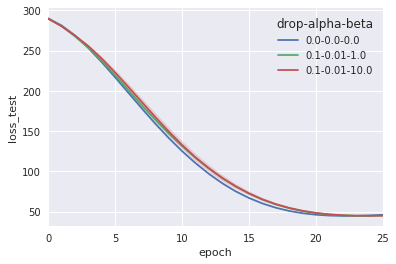

In [118]:
sns.tsplot(time="epoch", value="loss_test",
                 unit="experiment", condition="drop-alpha-beta",
                 data=df_tot, ci=[68])
           
plt.xlim(0,25.0)
plt.show()

Now for experimenting with low dropouts and very low alphas

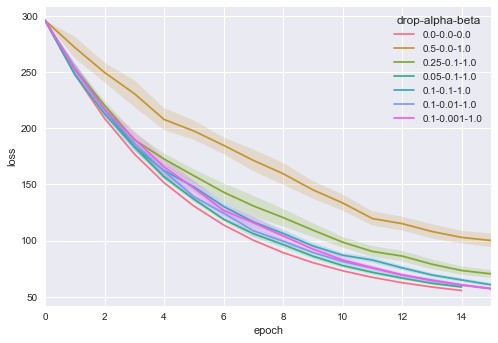

In [184]:
sns.tsplot(time="epoch", value="loss",
                 unit="experiment", condition="drop-alpha-beta",
                 data=df_tot, ci=[68])
           
plt.show()

In [178]:

df_tot.to_csv('ada-SGD-multiexp-alpha-beta-drop_2.csv')

Now try the same things with Adam and with a bigger network

In [11]:
test_list = [
    df_control, #0-0-0
    
    
    
    
    
    
    
#    df_test000, #0.5-0.0-1.0
#    df_test4, #0.5-0.1-1.0
    
    df_test111, #0.25-0.1-1.0
#    df_test112, #0.1-0.1-1.0
    df_test113, #0.05-0.1-1.0
#    df_test114, #0.1-0.1-1.0 
    df_test115, #0.1-0.01-1.0
    df_test116, #0.1-0.001-1.0 
]

In [13]:
df_tot = pd.concat(test_list,axis=0)
df_tot = df_tot.reset_index(drop=False).rename(columns={'index':'epoch'})

def concat_tags(df):
    return df['grad_drop'].astype(str) + '-' + df['alpha'].astype(str) + '-' + df['beta'].astype(str)  

df_tot['drop-alpha-beta'] = df_tot.apply(concat_tags,axis=1)

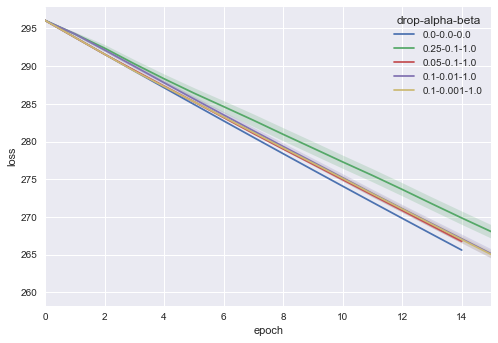

In [14]:
sns.tsplot(time="epoch", value="loss",
                 unit="experiment", condition="drop-alpha-beta",
                 data=df_tot, ci=[68])
           
plt.show()

In [15]:
df_test000 = run_exps(num_exps = 1, 
                   grad_drop = 0.0, 
                   alpha = 0.00, 
                   beta = 0.0, 
                   
                   tqdm_on=False)

starting exp 1


In [ ]:
df_control.to_csv('control.csv')